In [3]:

import os
import numpy as np 
import pandas as pd
from glob import glob
import tensorflow as tf
#import tensorflow_hub as hub
from IPython.display import clear_output as cls

# Data 
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2

#Directory Manipulation
import os
from sklearn.model_selection import train_test_split
import shutil

In [4]:
#pip freeze

In [5]:
# Define the root directory
root_dir = 'Monkeypox Skin Image Dataset/'
# Get the class names
class_names = os.listdir(root_dir)

# Create directories for the training, validation, and testing sets
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the filenames in each class directory into training, validation, and testing sets
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    filenames = os.listdir(class_dir)
    train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.25, random_state=42)
    
    # Create directories for the class in the training, validation, and testing sets
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Copy the images to the class directories in the training, validation, and testing sets
    for filename in train_filenames:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(train_class_dir, filename)
        shutil.copyfile(src_path, dst_path)
    
    for filename in val_filenames:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(val_class_dir, filename)
        shutil.copyfile(src_path, dst_path)
    
    for filename in test_filenames:
        src_path = os.path.join(class_dir, filename)
        dst_path = os.path.join(test_class_dir, filename)
        shutil.copyfile(src_path, dst_path)


In [7]:
root_path = 'Monkeypox Skin Image Dataset/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 4 
Class Names : ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']


In [8]:
import plotly.express as px

# Plot Pie Chart
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)

# Center the title
fig.update_layout(title={'x':0.48})

# Show the figure
fig.show()


In [9]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

# Data Load
train_ds = train_gen.flow_from_directory(train_dir, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32) 
valid_ds = valid_gen.flow_from_directory(val_dir, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32) 
test_ds = test_gen.flow_from_directory(test_dir, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)

Found 459 images belonging to 4 classes.
Found 155 images belonging to 4 classes.
Found 156 images belonging to 4 classes.


In [10]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

In [11]:
def load_image(path):
    '''This function will load the image present at the given location'''
    image = tf.cast(tf.image.resize(img_to_array(load_img(path))/255., (256,256)), tf.float32)
    return image

def show_image(image, title=None):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

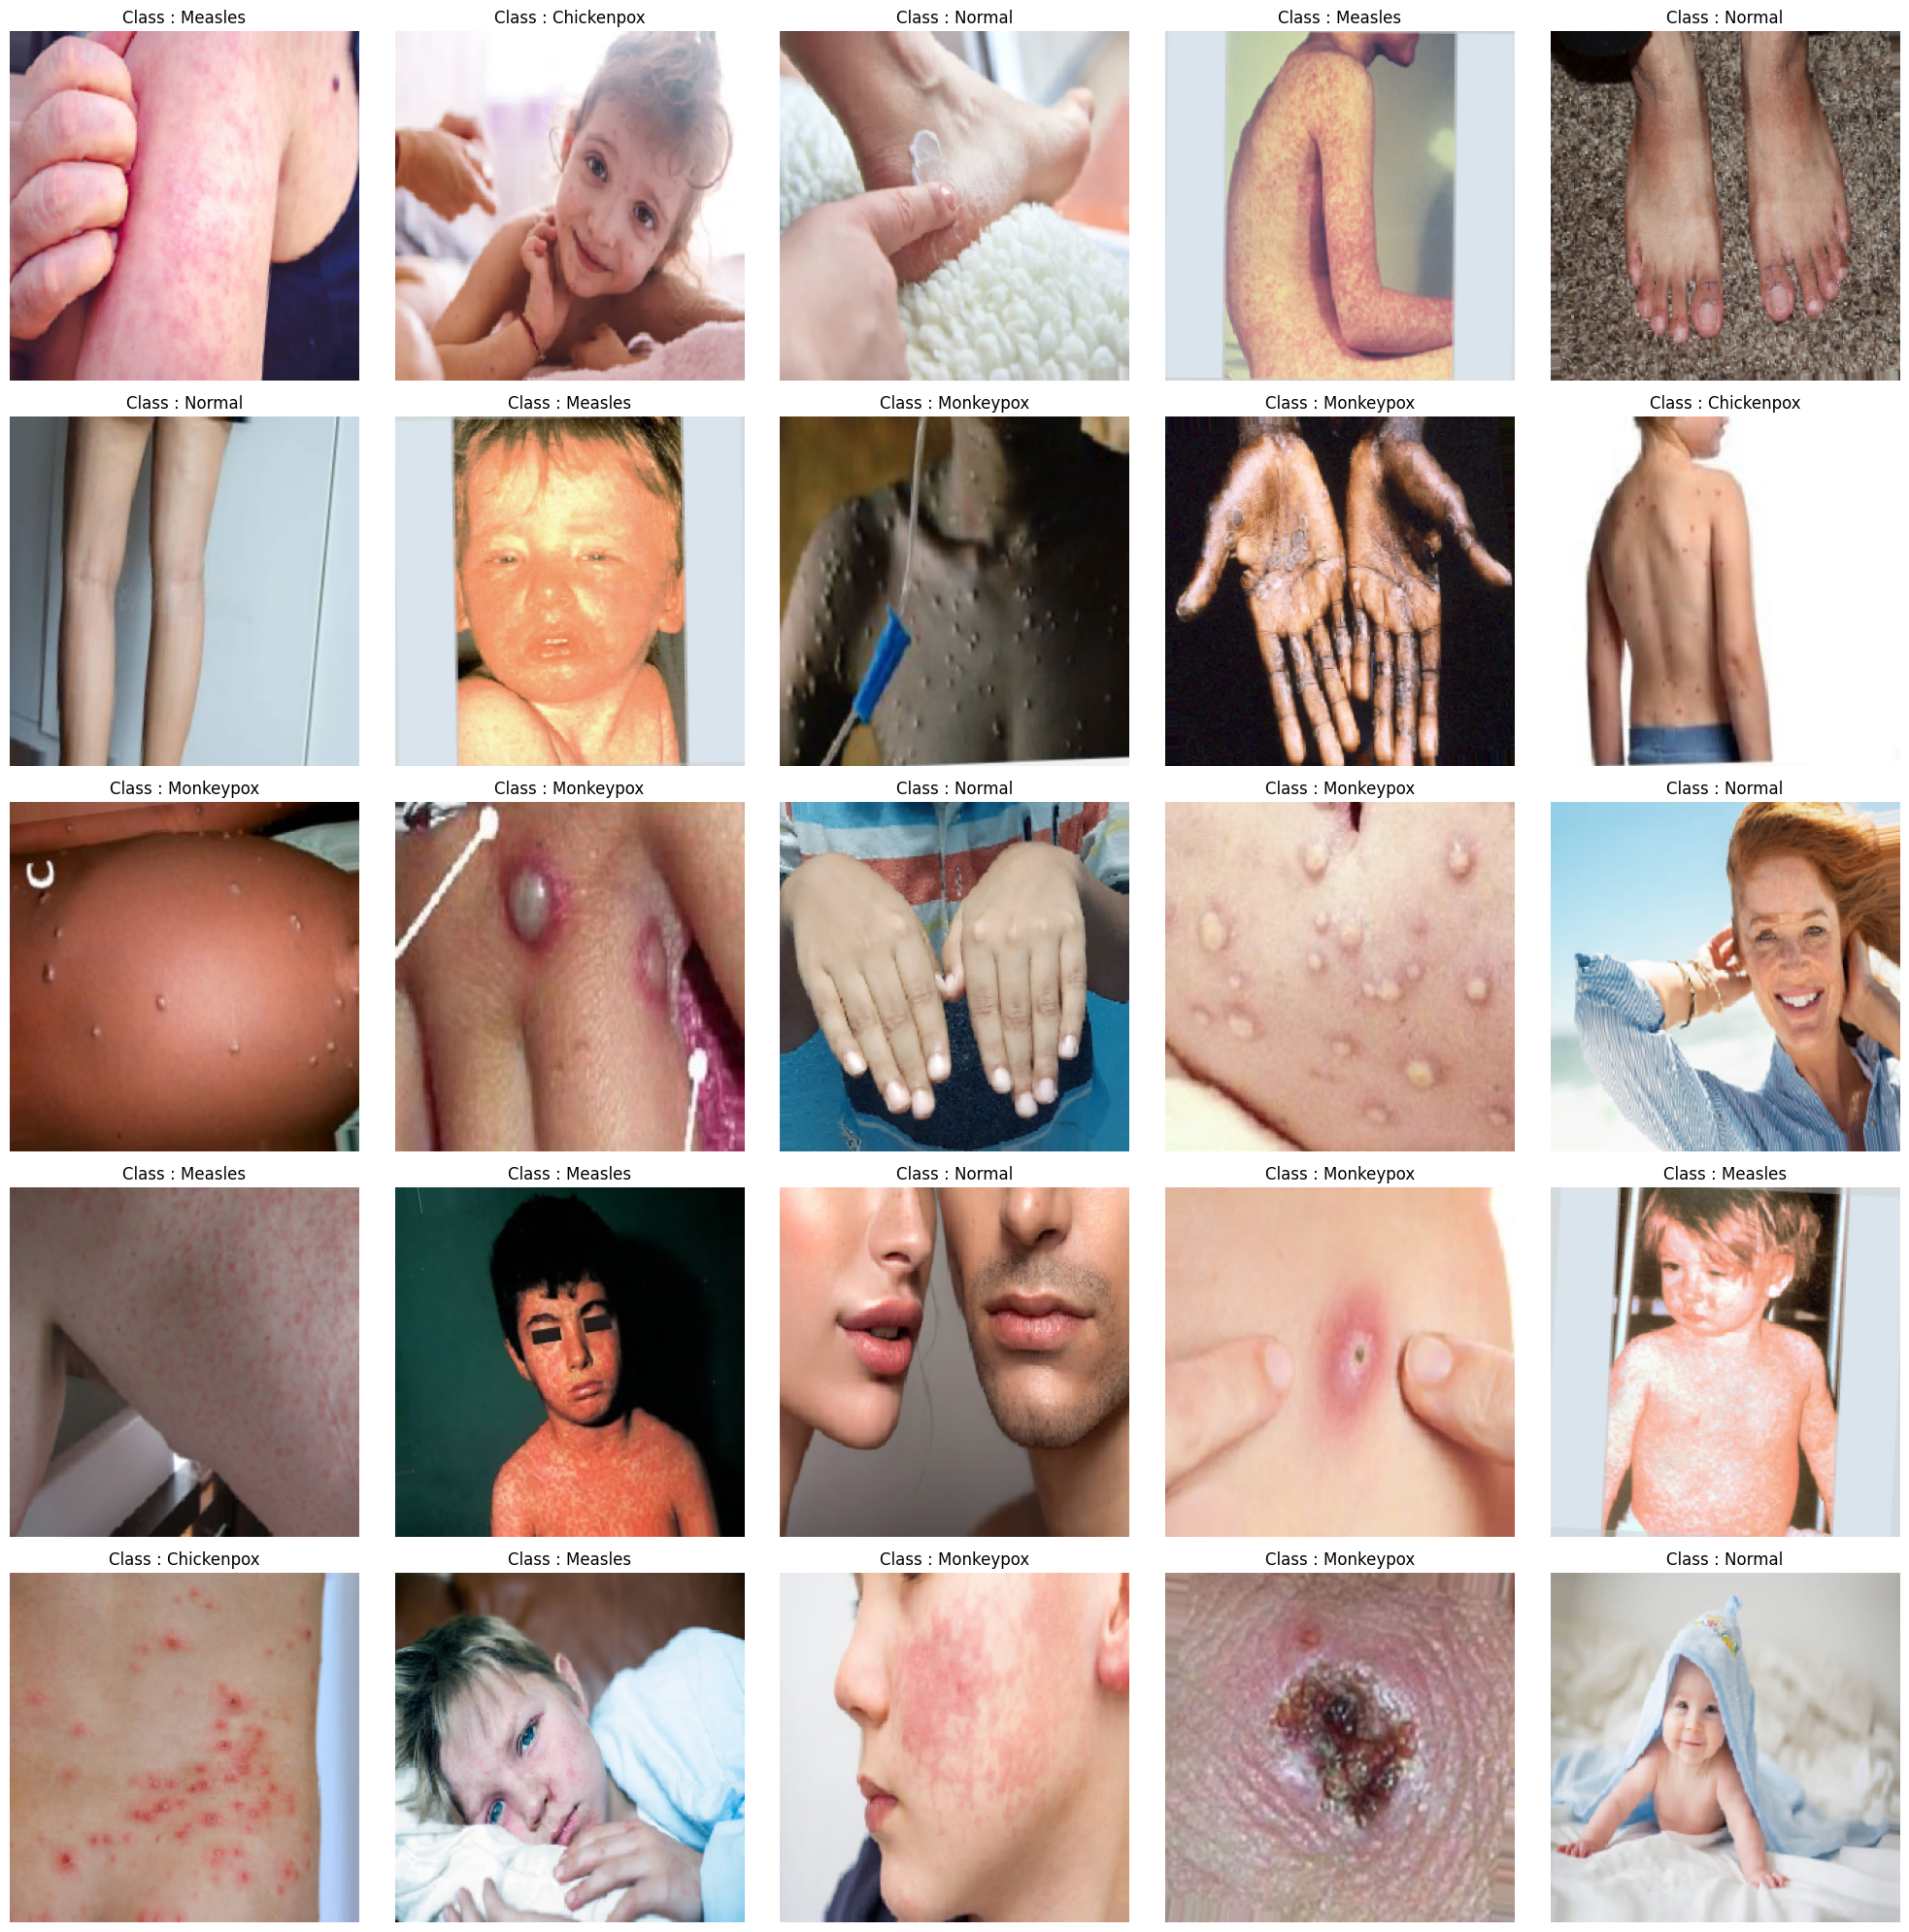

In [12]:
#Visulaize Training Images
show_images(data=train_ds)

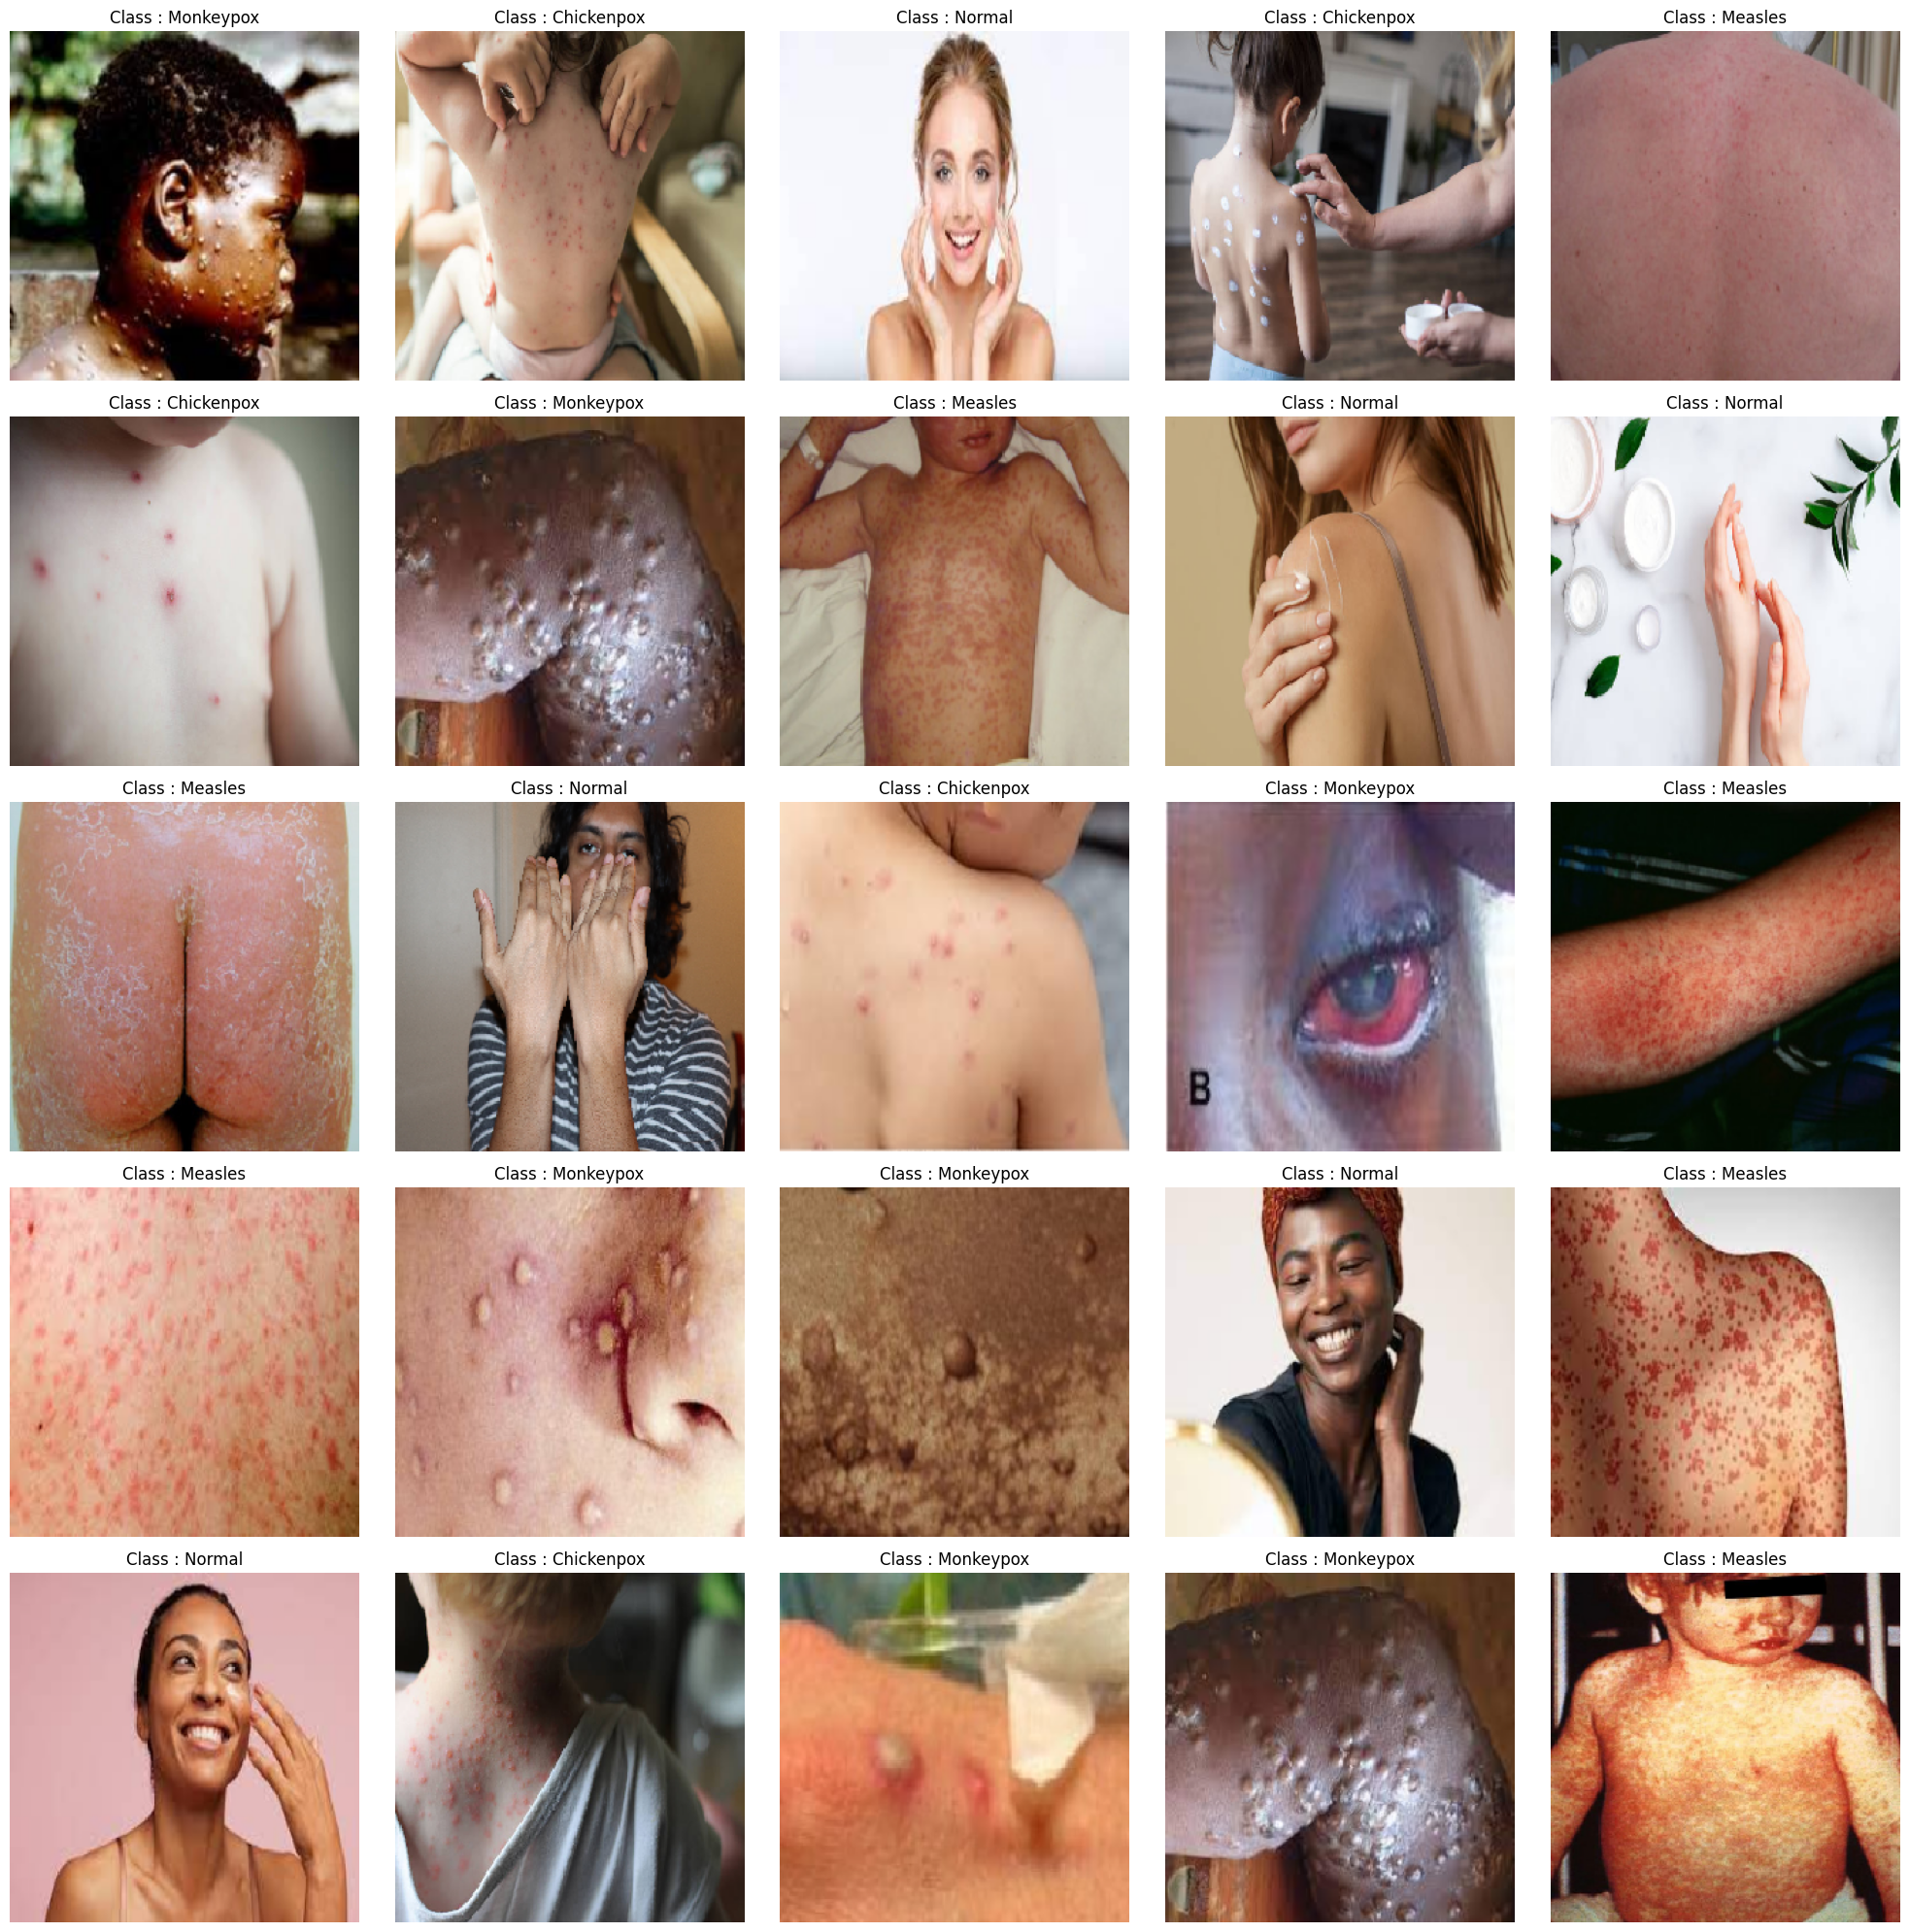

In [13]:
#Visualize Test Images
show_images(data=valid_ds)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 model as a feature extractor
base_model = ResNet50(weights='imagenet', include_top=False)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name='resnet-custom')

# Learning rate and optimizer
BATCH_SIZE = 32
lr = 1e-3 * BATCH_SIZE / 512
print(f"Learning rate : {lr}")

SCHEDULE_BOUNDARIES = [200, 300, 400]
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[lr, lr * 0.1, lr * 0.01, lr * 0.001],
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks
cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('resnet-custom.h5', save_best_only=True)
]

# Train model
history = model.fit(train_ds, validation_data=valid_ds, epochs=5, callbacks=cbs)


Learning rate : 6.25e-05
Epoch 1/5
15/15 [==============================] - 53s 3s/step - loss: 1.3243 - accuracy: 0.3508 - val_loss: 1.2620 - val_accuracy: 0.3806
Epoch 2/5
15/15 [==============================] - 55s 4s/step - loss: 1.2698 - accuracy: 0.3813 - val_loss: 1.2653 - val_accuracy: 0.3806
Epoch 3/5
15/15 [==============================] - 74s 5s/step - loss: 1.2654 - accuracy: 0.3747 - val_loss: 1.2599 - val_accuracy: 0.3806
Epoch 4/5
15/15 [==============================] - 67s 5s/step - loss: 1.2594 - accuracy: 0.3813 - val_loss: 1.2589 - val_accuracy: 0.3806
Epoch 5/5
15/15 [==============================] - 66s 4s/step - loss: 1.2606 - accuracy: 0.3813 - val_loss: 1.2602 - val_accuracy: 0.3806


In [15]:
model.evaluate(test_ds)

5/5 [==============================] - 14s 3s/step - loss: 1.2663 - accuracy: 0.3782


[1.266300082206726, 0.3782051205635071]

In [ ]:
show_images(model=model, data=test_ds)